# Look at Giulia's DCE compared to mine and clean it up 

### Notebook contents 
* I created DCE with rapid, ncalm, and snow off chm
* when I looked in ArcGIS, the ncalm and snow off where in weird locations, so let's see if rioxarray can fix this.

created by Cassie Lumbrazo\
date: October 2023\
python environment: **raster**

In [1]:
# import packages 
# %matplotlib widget
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

import geopandas as gpd
# import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rioxarray
import rasterio
# import rasterstats
import scipy

In [4]:
# open tifs 
tif_dce_rapid = rioxarray.open_rasterio("/storage/lumbraca/RAPID/dce_rapid_chmws.tif", masked=True)
tif_dce_ncalm = rioxarray.open_rasterio("/storage/lumbraca/NCALM_sites/cer/cer_dce.tif", masked=True)


tif_giulia_dce_rapid = rioxarray.open_rasterio("/storage/lumbraca/RAPID/giulia_dce/giulia_dce_rapid_chmws.tif", masked=True)
tif_giulia_dce_ncalm = rioxarray.open_rasterio("/storage/lumbraca/RAPID/giulia_dce/giulia_dce_ncalm_chmws.tif", masked=True)
tif_giulia_dce_snowoff = rioxarray.open_rasterio("/storage/lumbraca/RAPID/giulia_dce/giulia_dce_snowoff_chm.tif", masked=True)

# Put it all together 
ds = xr.Dataset({"dce_rapid":tif_dce_rapid, # TO MATCH with 
                 "dce_ncalm":tif_dce_ncalm.rio.reproject_match(tif_dce_rapid, resampling = rasterio.enums.Resampling.bilinear),
                 "giulia_dce_rapid":tif_giulia_dce_rapid.rio.reproject_match(tif_dce_rapid, resampling = rasterio.enums.Resampling.bilinear),
                 "giulia_dce_ncalm":tif_giulia_dce_ncalm.rio.reproject_match(tif_dce_rapid, resampling = rasterio.enums.Resampling.bilinear),
                 "giulia_dce_snowoff":tif_giulia_dce_snowoff.rio.reproject_match(tif_dce_rapid, resampling = rasterio.enums.Resampling.bilinear)})


In [5]:
# close all the datasets to save memory 
tif_dce_ncalm.close()
tif_dce_rapid.close()

tif_giulia_dce_rapid.close()
tif_giulia_dce_ncalm.close()
tif_giulia_dce_snowoff.close()

In [6]:
ds

<xarray.Dataset>
Dimensions:             (band: 1, x: 2564, y: 1388)
Coordinates:
  * band                (band) int64 1
  * x                   (x) float64 4.65e+05 4.65e+05 ... 4.676e+05 4.676e+05
  * y                   (y) float64 2.111e+05 2.111e+05 ... 2.097e+05 2.097e+05
    spatial_ref         int64 0
Data variables:
    dce_rapid           (band, y, x) float32 ...
    dce_ncalm           (band, y, x) float32 -1.292 -1.828 ... -3.084 -2.352
    giulia_dce_rapid    (band, y, x) float64 nan nan nan nan ... nan nan nan nan
    giulia_dce_ncalm    (band, y, x) float32 nan nan nan nan ... nan nan nan nan
    giulia_dce_snowoff  (band, y, x) float32 nan nan nan nan ... nan nan nan nan

In [7]:
# # Because this takes so long to create, let's save all the raw files into a netcdf, before cleaning up the dataset and resaving 
# ds.to_netcdf('/home/lumbraca/raster/data/rapid_model_rawdata_create_netcdf.nc')

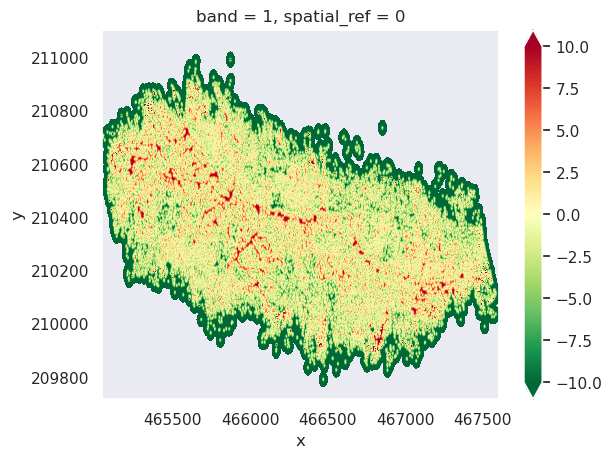

In [8]:
ds.dce_rapid.plot(cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''}) # just want to make sure the correct dce is uploaded 

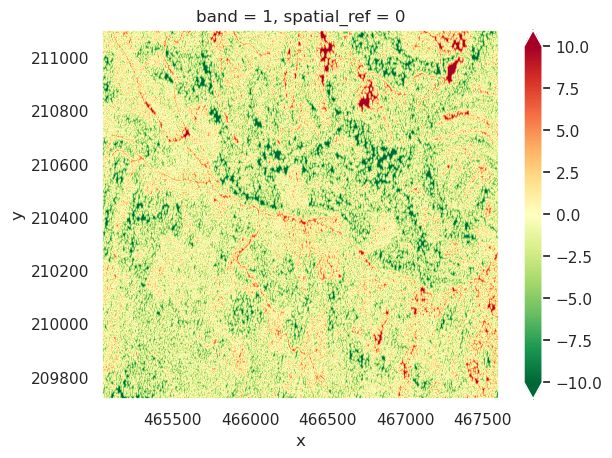

In [9]:
ds.dce_ncalm.plot(cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''}) # just want to make sure the correct dce is uploaded 

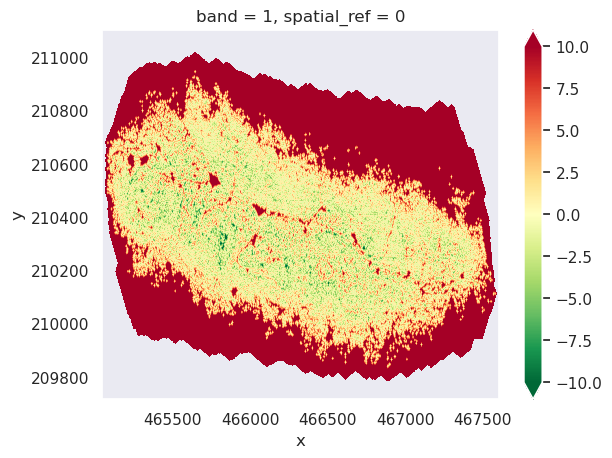

In [10]:
ds.giulia_dce_rapid.plot(cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})

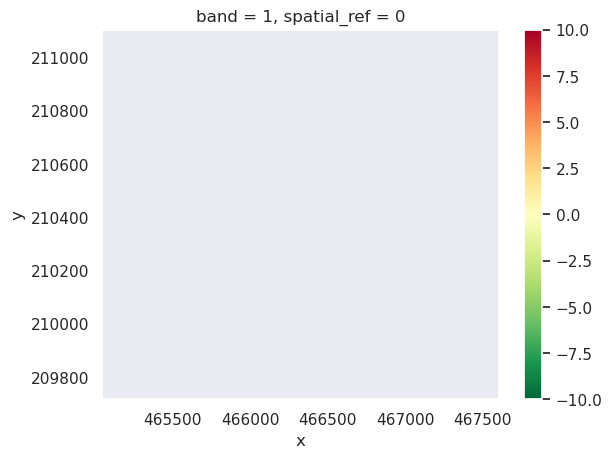

In [11]:
ds.giulia_dce_ncalm.plot(cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''}) 

# STOPPED HERE 
* there is something wrong with the dce from snow off and ncalm 
* So, I am just going to move the Giulia DCE for RAPID (which looks good) into the main netcdf and move on from here 

___________________________________________________________________________

So, the masked piles make a very small difference on the distrubitions (which is good)\
It seems we want to use a different method for removing negative snow depths in the RAPID data, so match the distrubition from the ncalm data more\
We can account for some verticle error in the drone, but saying anything ~30cm negative is really zero, or so, and see how it looks

In [24]:
# # testing to see if taking small negative values = 0 in rapid data helps the distribution
# ds.hs_rapid_set2_test = ds.hs_rapid_set2.where(ds.hs_rapid_set2 > 0, other=0)

## Create a buffer on DCE to remove edge effects 

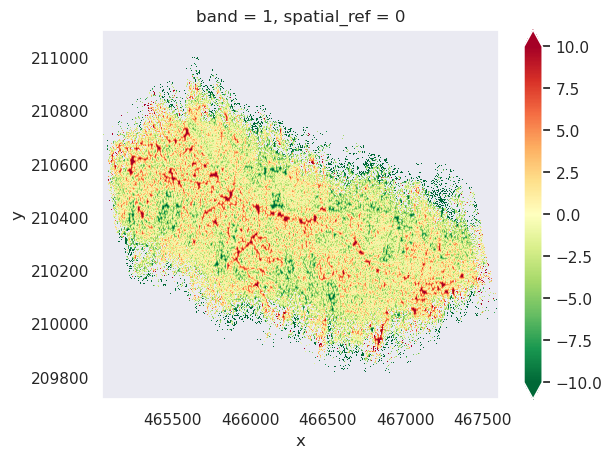

In [25]:
ds.dce_rapid.plot(cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''}) # just want to make sure the correct dce is uploaded 

In [26]:
# first creating a binary mask
# if there are values then 1, if not then 0 
dce_mask = ds.dce_rapid.copy(deep=True) # first copy dce 
dce_mask = dce_mask.fillna(-1000) # then filling the nans in the mask with 500 to make this easier
dce_mask = dce_mask.where(dce_mask < -50, 1) # where condition is FALSE, fill with 1 
dce_mask = dce_mask.where(dce_mask > -50, 0) # where condition is FALSE, fill with 0 

# now, we take the dce_mask and do the erosion thing with it to create the fixed mask 
fixed_mask = scipy.ndimage.binary_erosion(dce_mask, structure=np.ones((1,20,20))).astype(dce_mask.dtype) # had to add the 1 to the 50x50 for dimensions

# Perhaps smaller than 20x20 is okay for this dataset? I can go check the dce in ArcGIS Pro to see the distance, and just make sure to write it up.
# I checked, and we really need ~ 20 meters to account for the edge effects in the dce 

# add the fixed mask to the dataset 
ds['mask'] = xr.DataArray(fixed_mask,dims = ['band','y','x'])

# Now, go mask my OG dataset by the fixed_mask to remove the edges of dce 
ds['dce_rapid_raw'] = ds['dce_rapid'].copy(deep=True) # saving dce into a variable for the dataset 
ds['dce_rapid'] = ds['dce_rapid'].where(ds['mask'] >= 1) # resaving the mask dce into dce variable 

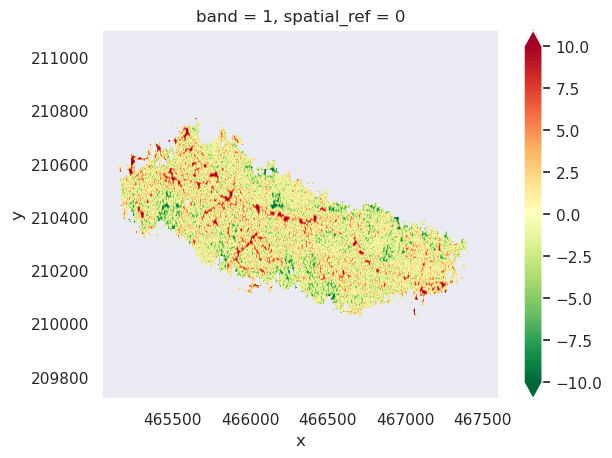

In [27]:
ds.dce_rapid.plot(cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''}) # just want to make sure the correct dce is uploaded 

### Set up the different dce classifications 

First, RAPID dataset.

In [28]:
# fix up dah classification for zero to be with negative values
dah_reclass = ds['dah'].copy(deep=True)

dah_reclass = dah_reclass.where(dah_reclass <= 0, 1) # xarray.where cond = False, replace with value
dah_reclass = dah_reclass.where(dah_reclass > 0, -1)

# fix up dce classification so that it's clear groups
# xarray .where function becomes a mask when you use the ~ to negate the statement 

dce_reclass = ds['dce_rapid'].copy(deep=True) # where cond = False, replace (unless we use the ~)                                

dce_reclass = dce_reclass.where(~(dce_reclass > 30), drop=True)                       # droping any gaps that are bigger than 20
dce_reclass = dce_reclass.where(~(( 3 <  dce_reclass) & (dce_reclass <=  30)), 500) # group 1: Large Gaps      3 <  DCE <=  20
dce_reclass = dce_reclass.where(~(( 1 <  dce_reclass) & (dce_reclass <=  3)), 400) # group 2: Small Gaps      1 <  DCE <=  3
dce_reclass = dce_reclass.where(~((-1 <= dce_reclass) & (dce_reclass <=  1)), 300) # group 3: Edges          -1 <= DCE <=  1
dce_reclass = dce_reclass.where(~((-3 <= dce_reclass) & (dce_reclass <  -1)), 200) # group 4: Small Clusters -3 <= DCE <=  1
dce_reclass = dce_reclass.where(~(dce_reclass <-3), 100)                           # group 5: Large Clusters       DCE <= -3

ds['dah_reclass'] = dah_reclass.copy(deep=True)
ds['dce_rapid_reclass'] = dce_reclass.copy(deep=True)

# Also saving these into the xarray dataframe, then else is nan for each group 
# only for my dce classification, but Giulia's for now 
# ds['dce_rapid_largeclusters'] = ds.dce_reclass.where(ds.dce_reclass == 100)
# ds['dce_rapid_smallclusters'] = ds.dce_reclass.where(ds.dce_reclass == 200)
# ds['dce_rapid_canopyedges']   = ds.dce_reclass.where(ds.dce_reclass == 300)
# ds['dce_rapid_smallgaps']     = ds.dce_reclass.where(ds.dce_reclass == 400)
# ds['dce_rapid_largegaps']     = ds.dce_reclass.where(ds.dce_reclass == 500)

Then, NCALM dataset. 

In [29]:
# fix up dce classification so that it's clear groups
# xarray .where function becomes a mask when you use the ~ to negate the statement 

dce_reclass = ds['dce_ncalm'].copy(deep=True) # where cond = False, replace (unless we use the ~)                                

dce_reclass = dce_reclass.where(~(dce_reclass > 30), drop=True)                       # droping any gaps that are bigger than 20
dce_reclass = dce_reclass.where(~(( 3 <  dce_reclass) & (dce_reclass <=  30)), 500) # group 1: Large Gaps      3 <  DCE <=  20
dce_reclass = dce_reclass.where(~(( 1 <  dce_reclass) & (dce_reclass <=  3)), 400) # group 2: Small Gaps      1 <  DCE <=  3
dce_reclass = dce_reclass.where(~((-1 <= dce_reclass) & (dce_reclass <=  1)), 300) # group 3: Edges          -1 <= DCE <=  1
dce_reclass = dce_reclass.where(~((-3 <= dce_reclass) & (dce_reclass <  -1)), 200) # group 4: Small Clusters -3 <= DCE <=  1
dce_reclass = dce_reclass.where(~(dce_reclass <-3), 100)                           # group 5: Large Clusters       DCE <= -3

ds['dce_ncalm_reclass'] = dce_reclass.copy(deep=True)

# Also saving these into the xarray dataframe, then else is nan for each group 
# only for my dce classification, but Giulia's for now 
# ds['dce_ncalm_largeclusters'] = ds.dce_reclass.where(ds.dce_reclass == 100)
# ds['dce_ncalm_smallclusters'] = ds.dce_reclass.where(ds.dce_reclass == 200)
# ds['dce_ncalm_canopyedges']   = ds.dce_reclass.where(ds.dce_reclass == 300)
# ds['dce_ncalm_smallgaps']     = ds.dce_reclass.where(ds.dce_reclass == 400)
# ds['dce_ncalm_largegaps']     = ds.dce_reclass.where(ds.dce_reclass == 500)

## Write to nedcdf 

Need to set everything to null again to make our main snow depth result 

In [30]:
# make all values of the dataset nan where the values of snow depth are nan 
ds = ds.where(ds.hs_rapid_set2_maskpiles.notnull())

# then, save the main snow depth dataset we are going to use for future code 
ds['hs_rapid'] = ds['hs_rapid_set2_maskpiles'].copy(deep=True) # saving dce into a variable for the dataset

# and add the canopy height model above snow to the dataset
ds['chmas_rapid'] = ds['chmws_rapid_set1'] - ds['hs_rapid']

In [31]:
ds

<xarray.Dataset>
Dimensions:                  (band: 1, y: 1388, x: 2564)
Coordinates:
  * band                     (band) int64 1
  * x                        (x) float64 4.65e+05 4.65e+05 ... 4.676e+05
  * y                        (y) float64 2.111e+05 2.111e+05 ... 2.097e+05
    spatial_ref              int64 0
Data variables: (12/32)
    hs_rapid_set1            (band, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    hs_rapid_set2            (band, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    hs_rapid_set3            (band, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    hs_rapid_set2_maskpiles  (band, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    hs_rapid_set3_maskpiles  (band, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    chmws_rapid_set1         (band, y, x) float32 nan nan nan ... nan nan nan
    ...                       ...
    dce_rapid_raw            (band, y, x) float32 nan nan nan ... nan nan nan
    dah_reclass              (band, y, x) float32 1.0 1.0 1.0 ... 1.0 1.0 1.0
    dce_rapid_reclass        (band, y, x) float32 nan nan nan ... nan nan nan
    dce_ncalm_reclass        (band, y, x) float32 nan nan nan ... nan nan nan
    hs_rapid                 (band, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    chmas_rapid              (band, y, x) float32 nan nan nan ... nan nan nan

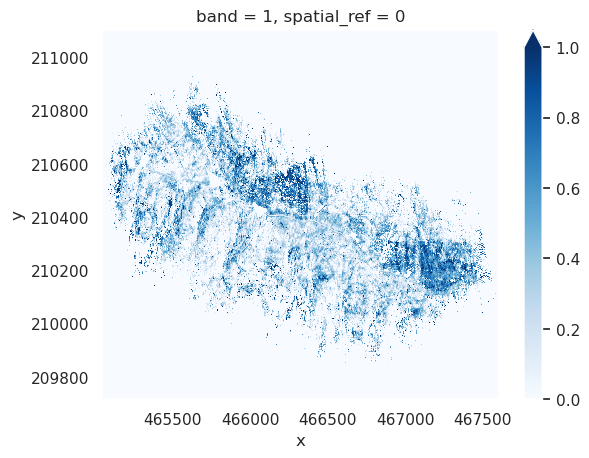

In [32]:
ds['hs_rapid'].plot(cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})

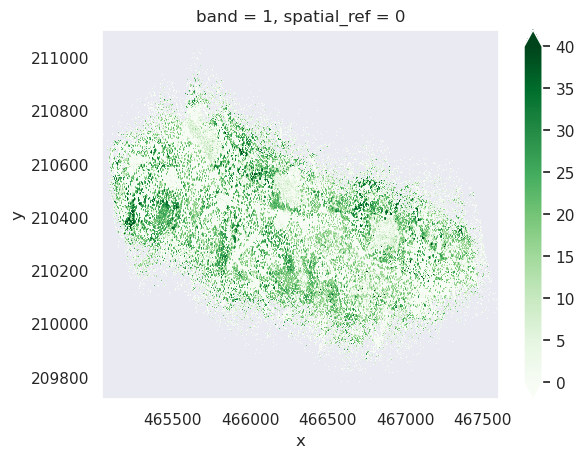

In [36]:
ds['chmas_rapid'].plot(cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''})

In [34]:
# ds.to_netcdf('/home/lumbraca/raster/data/rapid_model_cleandata_create_netcdf_cutatzero.nc') # for the snow depth values cut a zero
ds.to_netcdf('/home/lumbraca/raster/data/rapid_model_cleandata_create_netcdf_negtozero.nc') # for the snow depth values negative to zeros

In [35]:
ds.close()